In [ ]:
import numpy as np
import pandas as pd
import tarfile
import skimage.exposure
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import itertools
import time


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
folder_path = r'D:\Mines Paris-PSL\S4E\Machine learning\Exercises\Exercise_3\photo'

color_hist_feature = []
sift_features = []

# Create a SIFT object
sift = cv2.SIFT_create()

# Lists to store features and corresponding labels
features = []
labels = []

l_descp = []
l_hist = []

max_descriptors = 0
max_hist = 0
max_bow = 0

num_clusters = 10

# Iterate over all files and subfolders in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        # Check if the file is an image (you can adjust the condition based on your image file extensions)
        if file.endswith(('.jpg', '.png', '.jpeg')):
            # Access the image file path
            image_path = os.path.join(root, file)

            image = plt.imread(image_path)
            
            # Create histograms
            hist_phase, bins_phase = skimage.exposure.histogram(image)
            #color_hist_feature.append(hist_phase)

            # Assign visual words to each image and construct the BoVW representation
            bovw_features = []
            
            #Create a SIFT feature extraction
            # Detect and compute SIFT features

            # Convert the image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            keypoints, descriptors = sift.detectAndCompute(gray, None)
            
            # Check if descriptors are computed
            if descriptors is not None or descriptors.shape[0] != 0:

                # Extract the label from the folder name
                labels.append(os.path.basename(root))

                #Bag of words
                kmeans = KMeans(n_clusters=num_clusters)
                kmeans.fit(descriptors)

                bow_vector = kmeans.predict(descriptors)

                # Determine the maximum sizes of descriptors and histograms
                max_descriptors = max(max_descriptors, len(descriptors))
                max_hist = max(max_hist, len(hist_phase))
                mex_bow = max(max_bow, len(bow_vector))

                #Append the 2 features 
                features.append([descriptors.flatten(), hist_phase, bow_vector])
                l_descp.append(len(descriptors))
                l_hist.append(len(hist_phase))

# Pad or truncate the features to a fixed size
for i in range(len(features)):
    descriptors = features[i][0]
    hist_phase = features[i][1]
    bow_vector = features[i][2]

    pad_descriptors = max_descriptors - descriptors.shape[0]
    pad_hist = max_hist - len(hist_phase)
    pad_bow = max_bow - bow_vector.shape[0]

    if pad_descriptors > 0:
        descriptors = np.pad(descriptors, ((0, pad_descriptors), (0, 0)), mode='constant')
    else:
        descriptors = descriptors[:max_descriptors]

    if pad_hist > 0:
        hist_phase = np.pad(hist_phase, (0, pad_hist), mode='constant')
    else:
        hist_phase = hist_phase[:max_hist]
    
    if pad_bow > 0:
        bow_vector = np.pad(bow_vector, (0, pad_bow), mode='constant')
    else:
        bow_vector = bow_vector[:max_bow]

    # Reshape hist_phase to a 1D array
    hist_phase = hist_phase.flatten()
    bow_vector = bow_vector.flatten()

    features[i] = np.concatenate((descriptors.flatten(), hist_phase, bow_vector), axis=0)

c:\miniconda\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\miniconda\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Create an MLP classifier
mlp = MLPClassifier()

# Define the parameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, cv=5)

start = time.time()

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

fit_time = time.time() - start

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
mlp_best = MLPClassifier(**best_params)
mlp_best.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using plot_confusion_matrix
plot_confusion_matrix(mlp_best, X_test, y_test, display_labels=np.unique(np.array(labels)))
plt.title('Confusion Matrix')
plt.show()

print("fit time", fit_time)

c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Opti

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score: 0.3070539419087137
Accuracy: 0.32450331125827814


c:\miniconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


TypeError: plot_confusion_matrix() missing 1 required positional argument: 'y_true'

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Score: 0.2921161825726141
Accuracy: 0.33112582781456956


c:\miniconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


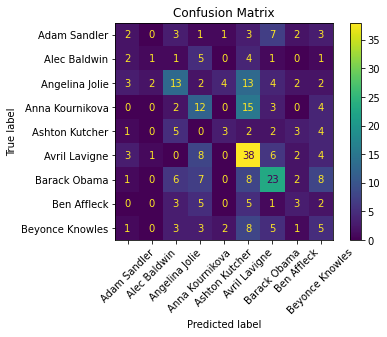

fit time 2.773326873779297


In [ ]:
knn = KNeighborsClassifier()

# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5)

start = time.time()

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

fit_time = time.time() - start

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using plot_confusion_matrix
plot_confusion_matrix(knn_best, X_test, y_test, display_labels=np.unique(np.array(labels)), xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

print("fit time", fit_time)

Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best Score: 0.2091286307053942
Accuracy: 0.25496688741721857


c:\miniconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


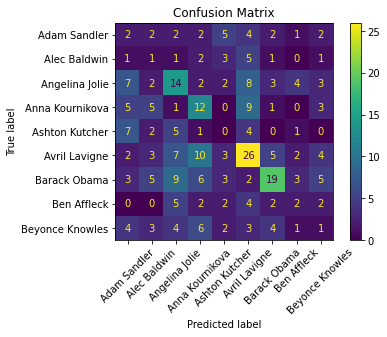

fit time 21.493425607681274


In [ ]:
# Create an SVM classifier
svm = SVC()

# Define the parameter grid for tuning
#'C': [0.1, 1, 10],
    #'kernel': ['linear', 'rbf'],
    #'gamma': [0.1, 1, 10]
param_grid = {'C': [0.1], 'gamma': [0.1], 'kernel': ['linear']}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, cv=5)

start = time.time()

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)


fit_time = time.time() - start

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
svm_best = SVC(**best_params)
svm_best.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using plot_confusion_matrix
plot_confusion_matrix(svm_best, X_test, y_test, display_labels=np.unique(np.array(labels)), xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

print("fit time", fit_time)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.3385892116182573
Accuracy: 0.3973509933774834


c:\miniconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


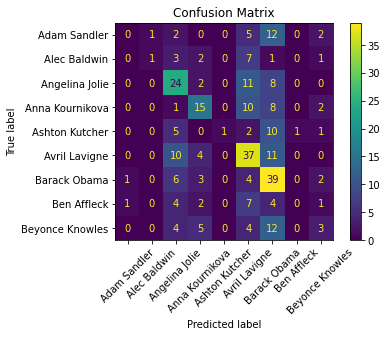

21.902116298675537


In [ ]:
# Create a Random Forest classifier
rf = RandomForestClassifier()

# Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}

# Define the parameter grid for tuning
param_grid = {'max_depth': [10], 'max_features': ['sqrt'], 'min_samples_split': [2], 'n_estimators': [300]}
#param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [None, 5, 10],
    #'min_samples_split': [2, 5, 10],
    #'max_features': ['auto', 'sqrt', 'log2']
#}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5)

start = time.time()

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

fit_time = time.time() - start

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using plot_confusion_matrix
plot_confusion_matrix(rf_best, X_test, y_test, display_labels=np.unique(np.array(labels)), xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

print(fit_time)

In [ ]:
## Creation of the set of images

folder_path = r'D:\Mines Paris-PSL\S4E\Machine learning\Exercises\Exercise_3\photo'

images = []
labels = []

# Iterate over all files and subfolders in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        # Check if the file is an image (you can adjust the condition based on your image file extensions)
        if file.endswith(('.jpg', '.png', '.jpeg')):
            # Access the image file path
            image_path = os.path.join(root, file)

            image = plt.imread(image_path)

            images.append(image)
            labels.append(os.path.basename(root))

images = np.array(images)
labels = np.array(labels)

In [ ]:
## Squeezenet structure

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Activation

def fire_module(x, squeeze, expand):
    squeezed = Conv2D(squeeze, (1, 1), activation='relu')(x)
    expand1x1 = Conv2D(expand, (1, 1), activation='relu')(squeezed)
    expand3x3 = Conv2D(expand, (3, 3), padding='same', activation='relu')(squeezed)
    return concatenate([expand1x1, expand3x3])

def SqueezeNet(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(96, (7, 7), strides=(2, 2), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)

    x = Conv2D(num_classes, (1, 1), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

# Example usage:
input_shape = X_train.shape[1:]  # Input image shape
num_classes = 1000  # Number of output classes
model = SqueezeNet(input_shape, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 96)   14208       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 96)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 16)   1552        ['max_pooling2d[0][0]']      

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import RMSprop

# Define the number of folds for cross-validation and other hyperparameters
n_folds = 5  # Number of folds for cross-validation
learning_rate = 0.001
batch_size = 32
epochs = 100

# Encode the labels
label_encoder = LabelEncoder()
labels_deep = label_encoder.fit_transform(labels)

# Initialize lists to store the evaluation metrics for each fold
val_accuracy_per_fold = []

# Perform cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels_deep)):
    print(f"Fold {fold + 1}")
    X_train_fold = images[train_index]
    y_train_fold = labels_deep[train_index]
    X_val_fold = images[val_index]
    y_val_fold = labels_deep[val_index]

    # Encode the labels
    #label_encoder = LabelEncoder()
    #y_train_fold = label_encoder.fit_transform(y_train_fold)
    #y_val_fold = label_encoder.fit_transform(y_val_fold)

    # Define the input shape and number of classes
    input_shape = X_train.shape[1:]
    num_classes = len(np.unique(labels))

    # Create the LeNet model
    model = SqueezeNet(input_shape, num_classes)

    optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    start = time.time()

    history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold))

    fit_time = time.time() - start

    # Evaluate the model on validation data
    y_val_pred = model.predict(X_val_fold)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    y_val_true_labels = y_val_fold
    #np.argmax(np.reshape(y_val_fold, (-1, 1)), axis=1)
    val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)

    val_accuracy_per_fold.append(val_accuracy)

# Calculate and display the mean and standard deviation of the evaluation metrics across folds
print("Cross-validation results:")
print(f"Mean validation accuracy: {np.mean(val_accuracy_per_fold):.4f} (+/- {np.std(val_accuracy_per_fold):.4f})")
print("fit time", fit_time)

Fold 1
Epoch 1/100
38/38 [==============================] - 19s 411ms/step - loss: 2.1618 - accuracy: 0.1867 - val_loss: 2.1399 - val_accuracy: 0.1987
Epoch 2/100
38/38 [==============================] - 16s 413ms/step - loss: 2.1436 - accuracy: 0.1793 - val_loss: 2.1362 - val_accuracy: 0.1987
Epoch 3/100
38/38 [==============================] - 16s 431ms/step - loss: 2.1391 - accuracy: 0.1942 - val_loss: 2.1310 - val_accuracy: 0.1987
Epoch 4/100
38/38 [==============================] - 15s 403ms/step - loss: 2.1347 - accuracy: 0.1959 - val_loss: 2.1927 - val_accuracy: 0.2053
Epoch 5/100
38/38 [==============================] - 15s 400ms/step - loss: 2.1431 - accuracy: 0.2041 - val_loss: 2.0978 - val_accuracy: 0.2053
Epoch 6/100
38/38 [==============================] - 16s 409ms/step - loss: 2.1053 - accuracy: 0.2274 - val_loss: 2.0756 - val_accuracy: 0.2152
Epoch 7/100
38/38 [==============================] - 16s 414ms/step - loss: 2.1239 - accuracy: 0.2191 - val_loss: 2.1270 - val_ac

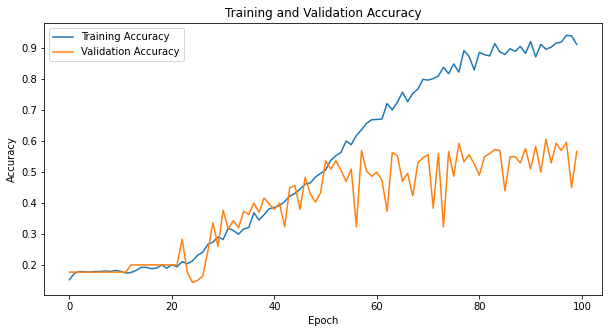

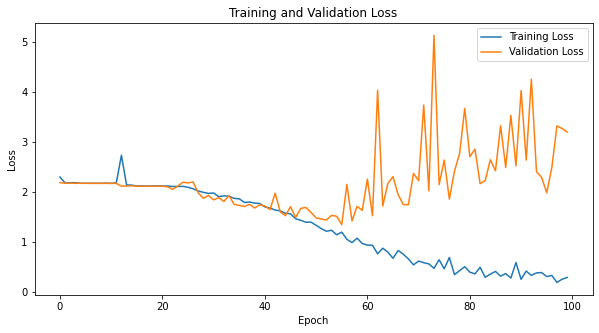

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store the training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


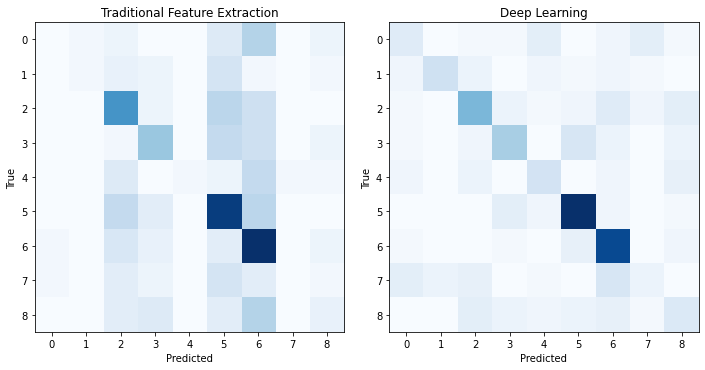

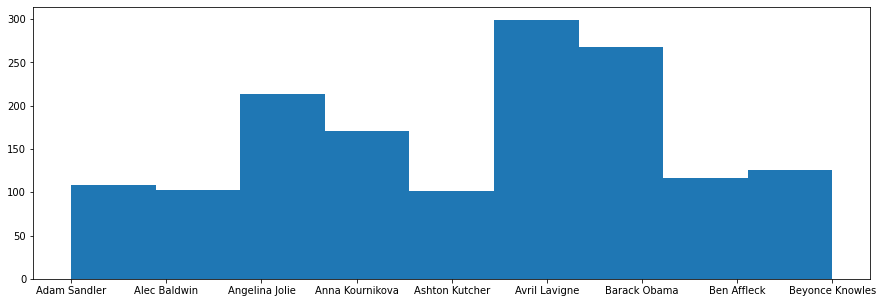

dict_keys(['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie', 'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne', 'Barack Obama', 'Ben Affleck', 'Beyonce Knowles'])


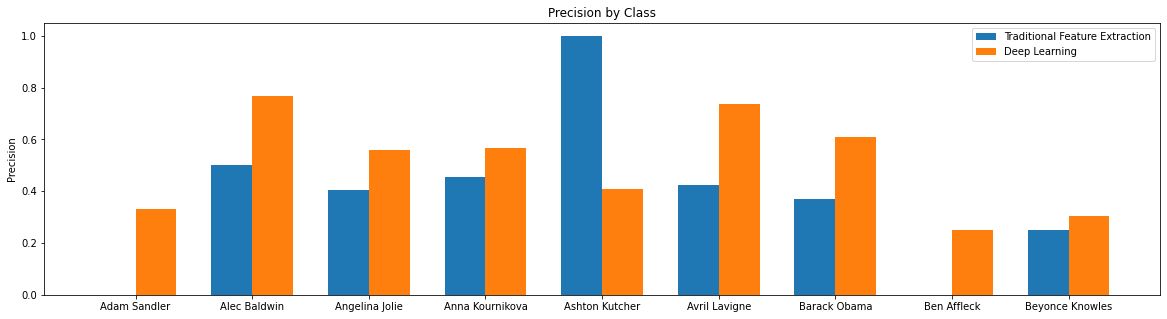

There is no significant difference between the two approaches.


In [ ]:
## Detailed comparison : Squeezenet and Random Forest

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from scipy.stats import ttest_rel
from collections import Counter

# Assume you have obtained the predictions and true labels for each approach
traditional_predictions = y_pred
deep_learning_predictions = y_val_pred_labels
true_labels_deep_learning = y_val_true_labels
true_labels_traditional = y_test

# Compute the confusion matrices
traditional_cm = confusion_matrix(y_test, y_pred)
deep_learning_cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)

# Plot the confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(traditional_cm, cmap='Blues')
axes[0].set_title('Traditional Feature Extraction')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[1].imshow(deep_learning_cm, cmap='Blues')
axes[1].set_title('Deep Learning')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

#Plot Class
plt.figure(figsize=(15,5))
plt.hist(labels, bins = 9)
plt.show()

# Calculate precision, recall, and F1-score for each class
traditional_metrics = precision_recall_fscore_support(true_labels_traditional, traditional_predictions, average=None)
deep_learning_metrics = precision_recall_fscore_support(true_labels_deep_learning, deep_learning_predictions, average=None)

# Plot class-specific metrics
classes = Counter(labels)
print(classes.keys())
x = np.arange(len(classes.keys()))
width = 0.35
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x - width/2, traditional_metrics[0], width, label='Traditional Feature Extraction')
ax.bar(x + width/2, deep_learning_metrics[0], width, label='Deep Learning')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Precision')
ax.set_title('Precision by Class')
ax.legend()
plt.show()

# Perform statistical test
_, p_value = ttest_rel(traditional_metrics[0], deep_learning_metrics[0])
if p_value < 0.05:
    print("There is a significant difference between the two approaches.")
else:
    print("There is no significant difference between the two approaches.")
